# Regression analysis
In this section, we try to quantify the linear relationship between various covariates and the success metric of choice. By success metric, we mean box office / IMDb ratings / number of oscars / revenue / metacritic rating.

## Dataset incompleteness
In this subsection we plot the dataset's incompleteness. The main problems with our dataset, which are consistent among other analyses we are doing as well is that there are some values missing and it is different ones for each of the success metrics.

In [1]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
sys.path.append('../utils')
from tropes_utils import plot_missing_data

### Merge all dataframes into one

In [2]:
movies = pd.read_pickle('../../pickles/cmu_imdb_tmdb_wikidata_merged.pkl')
metacritic = pd.read_pickle('../../pickles/metacritic_df.pkl')
imdb = pd.read_pickle('../../pickles/imdb_data.pkl')
movie_scores = pd.read_pickle('../../pickles/movie_scores.pkl')

/Users/adamborgula/.pyenv/versions/3.12.7/envs/epfl-ai/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


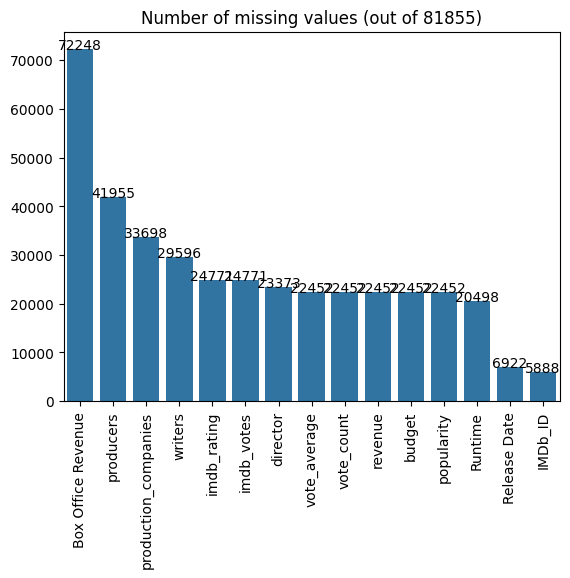

In [3]:
plot_missing_data(movies)

Let's more closely examine the covariates **producers, production_companies, writers, imdb_rating, imdb_votes, director, vote_average, vote_count, revenue, budget and popularity**

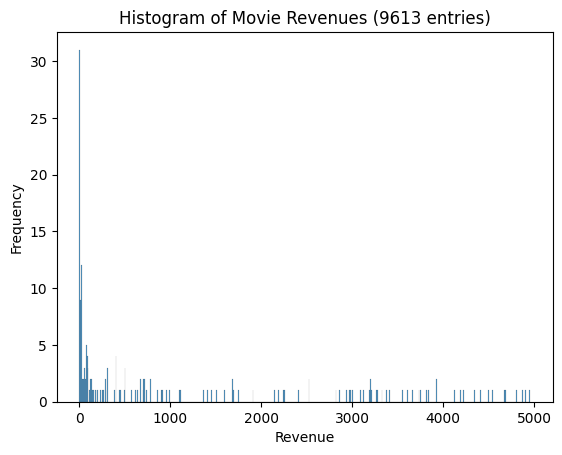

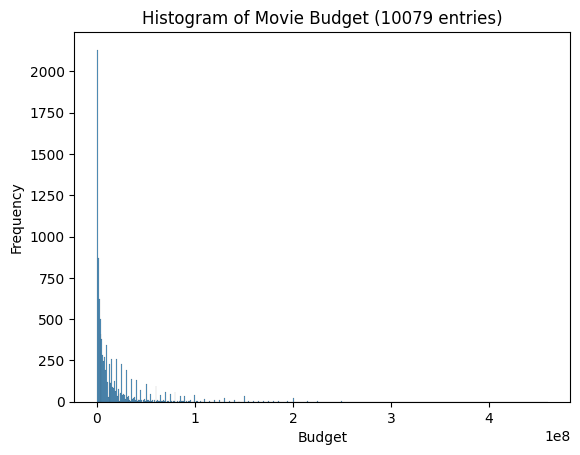

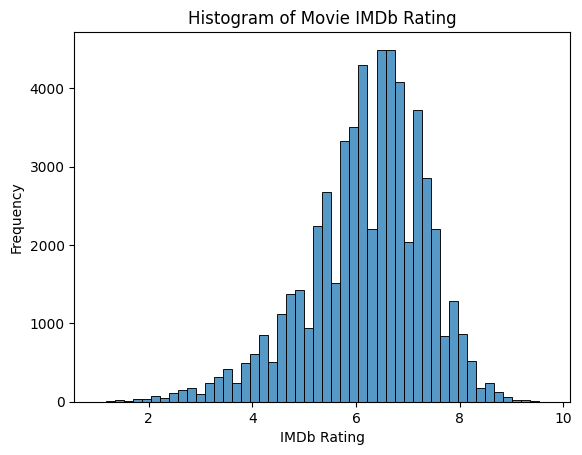

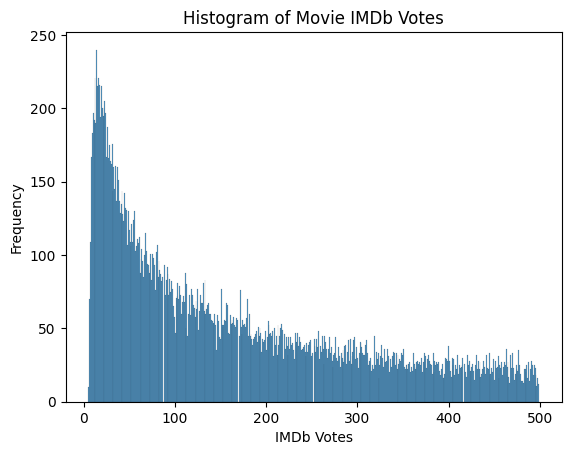

In [4]:

movies_positive_revenue = movies[movies['revenue'] > 0]
# plt.figure(figsize=(10, 6))
sns.histplot(movies_positive_revenue['revenue'][movies['revenue'] < 5000].dropna(), bins=500, kde=False)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title(f'Histogram of Movie Revenues ({len(movies_positive_revenue)} entries)')
plt.show()

movies_positive_budget = movies[movies['budget'] > 0]
# plt.figure(figsize=(10, 6))
sns.histplot(movies_positive_budget['budget'].dropna(), bins=500, kde=False)
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title(f'Histogram of Movie Budget ({len(movies_positive_budget)} entries)')
plt.show()

# plt.figure(figsize=(10, 6))
sns.histplot(movies['imdb_rating'].dropna(), bins=50, kde=False)
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Movie IMDb Rating')
plt.show()

# plt.figure(figsize=(10, 6))
sns.histplot(movies['imdb_votes'][movies['imdb_votes'] < 500].dropna(), bins=500, kde=False)
plt.xlabel('IMDb Votes')
plt.ylabel('Frequency')
plt.title('Histogram of Movie IMDb Votes')
plt.show()

<Axes: xlabel='Box Office Revenue', ylabel='revenue'>

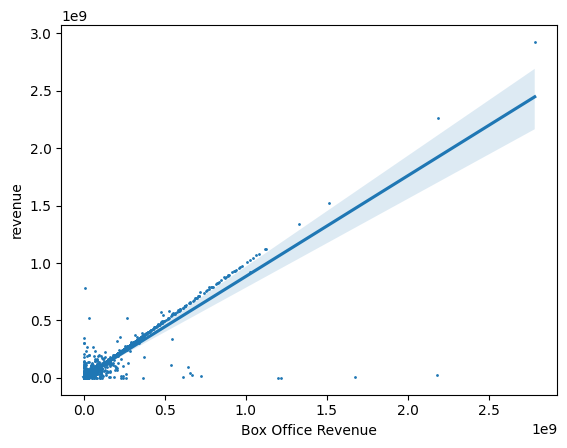

In [5]:
# plot revenue and box office correlation
# keep just columns where we have both values
movies_not_missing = movies[(movies['Box Office Revenue'].notnull()) & (movies['revenue'].notnull())]

# keep just columns where both values are above 0
movies_not_missing = movies_not_missing[movies_not_missing['revenue'] > 0]


plt.scatter(movies_not_missing['Box Office Revenue'], movies_not_missing['revenue'], s=1)

movies_not_missing['Box Office Revenue'] = movies_not_missing['Box Office Revenue'].astype(float)
movies_not_missing['revenue'] = movies_not_missing['revenue'].astype(float)

sns.regplot(x='Box Office Revenue', y='revenue', data=movies_not_missing, scatter=False)

We observed that a lot of revenue data is very low (0 or close to 0)

### Observations Conclusion
We can conclude from the above plots, that columns **revenue & budget** are incomplete and should not be used for later analysis.

**IMDb Votes & IMDb Rating** seem to be complete and we will therefore use them in the analysis. The number of votes varies dramatically, but that is to be expected. Ideally, we would want a high number of votes for each movies, but that is not the case. What we could do is only keep movies with the number of votes above certain **threshold**, e.g. 100+ votes. We choose not to do it this way as we want to keep the maximum amount of data related to the ratings.

The other variables which I want to look at are categorical, and therefore, we will encode them later when processing the data.

## Measuring success
We will do regression analysis on **2 success metrics**:
1. IMDb rating
2. box office

These 2 metrics were chosen, because each of them represents a different perspective. IMDb for audience reception and box office represents the profit from the tickets, which directly translates to 

### Covariate selection
We will only use a selection of covariates to make the predictions. Let us start by analysing their correlation.

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81855 entries, 0 to 81854
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wikipedia Movie ID    81855 non-null  int64  
 1   Freebase Movie ID     81855 non-null  object 
 2   Movie Name            81855 non-null  object 
 3   Release Date          74933 non-null  object 
 4   Box Office Revenue    9607 non-null   object 
 5   Runtime               61357 non-null  float64
 6   Language Freebase ID  81855 non-null  object 
 7   Language Name         81855 non-null  object 
 8   Country Freebase ID   81855 non-null  object 
 9   Country Name          81855 non-null  object 
 10  Genre Freebase ID     81855 non-null  object 
 11  Genre Name            81855 non-null  object 
 12  IMDb_ID               75967 non-null  object 
 13  vote_average          59403 non-null  float64
 14  vote_count            59403 non-null  float64
 15  revenue            

In [7]:
# drop all IDs (except IMDb, we drop that later)
columns_to_drop = ['Wikipedia Movie ID', 'Freebase Movie ID', 
                   'Language Freebase ID', 'Country Freebase ID', 'Genre Freebase ID', 
                   'revenue', 'budget', 'popularity', 'Runtime']

movies_cleaned = movies.drop(columns=columns_to_drop)

### Encode the categorical variables

In [8]:
# Encode the categorical variables

# drop 'popularity' column
def one_hot_encode(df, columns=['production_companies', 'director', 'writers', 'producers']):
  for col in columns:
    # Split each value on ', ' and create a column for each value (dummy encoding)
    dummies = df[col].str.get_dummies(sep=', ')
    # Rename the columns to include the original column name as a prefix
    dummies.columns = [f"{col}_{c}" for c in dummies.columns]
    # Concatenate the dummy columns to the original dataframe
    df = pd.concat([df, dummies], axis=1)
    # Drop the original column
    df.drop(col, axis=1, inplace=True)

def frequency_encode(df, columns=['production_companies', 'director', 'writers', 'producers']):
  df[columns] = df[columns].astype(str)
  
  for col in columns:
    # Explode the column to create one row per item in the list (if values are lists or comma-separated)
    if df[col].apply(lambda x: isinstance(x, str)).all():
      df[col] = df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    exploded_df = df.explode(col)

    # Calculate frequency of each unique value in the column
    col_freq = exploded_df[col].value_counts()

    # Map the frequency encoding back to the original DataFrame, averaging for multiple contributors
    df[f'{col}_frequency_encoded'] = df[col].apply(
      lambda x: sum(col_freq[val] for val in x if val in col_freq) / len(x) if isinstance(x, list) else None
    )

  return df

def target_encode(df, columns=['production_companies', 'director', 'writers', 'producers'], target_col='Box Office Revenue', encode_func=pd.Series.mean):
  df[columns] = df[columns].astype(str)

  for col in columns:
    # Explode the column to create one row per item in the list (if values are lists or comma-separated)
    if df[col].apply(lambda x: isinstance(x, str)).all():
      df[col] = df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    exploded_df = df.explode(col)

    # Calculate the target encoding (mean, median, etc.) for each unique value in the column
    col_target_mean = exploded_df.groupby(col)[target_col].apply(encode_func)

    # Map the encoding back to the original DataFrame, averaging for multiple contributors
    df[f'{col}_encoded'] = df[col].apply(
      lambda x: sum(col_target_mean[val] for val in x if val in col_target_mean) / len(x) if isinstance(x, list) else None
    )

  return df

def format_release_date(df):
  # Ensure the 'Release Date' column is not null before processing
  date_not_nan = df[df['Release Date'].notnull()]['Release Date']
  
  # Split the date strings by '-' into lists
  date_not_nan = date_not_nan.str.split('-')

  # Iterate over the rows
  for i, date in date_not_nan.items():
    # Assign year, month, and day based on the length of the split date
    if len(date) == 1:
      df.at[i, 'Release Year'] = int(date[0])
    elif len(date) == 2:
      df.at[i, 'Release Year'] = int(date[0])
      df.at[i, 'Release Month'] = int(date[1])
    elif len(date) == 3:
      df.at[i, 'Release Year'] = int(date[0])
      df.at[i, 'Release Month'] = int(date[1])
      df.at[i, 'Release Day'] = int(date[2])

  # Convert the columns to integer, preserving NaNs
  df['Release Year'] = df['Release Year'].astype('Int64')
  df['Release Month'] = df['Release Month'].astype('Int64')
  df['Release Day'] = df['Release Day'].astype('Int64')

  return df

def one_hot_encode_month(df):
    # Create one-hot encoded columns for the 'Release Month' column
    month_dummies = pd.get_dummies(df['Release Month'], prefix='Month', dummy_na=False)

    # Concatenate the one-hot encoded columns with the original dataframe
    df = pd.concat([df, month_dummies], axis=1)

    return df


movies_encoded = format_release_date(movies_cleaned)
movies_encoded = one_hot_encode_month(movies_encoded)
movies_encoded = frequency_encode(movies_encoded, columns=['production_companies', 'director']) # tmdb columns
movies_encoded = frequency_encode(movies_encoded, columns=['Language Name', 'Country Name', 'Genre Name']) # original columns

# movies_encoded.info()

We choose to do **one hot encoding** for the **month** & **frequency encoding** for the **other categorical variables** (producers, writers, etc.).

Alternative to frequency encoding is **target encoding**. However, it would directly utilize the target variable, so that would be "cheating" in a sense. Target encoding could be used, if we **split** the data into **train and test** data.

In [9]:
# Unwrap the lists in 'Language Name' column
all_languages = movies_encoded['Language Name'].explode()

# Count the number of unique language names
unique_languages = all_languages.nunique()
print(f'The number of unique language names is: {unique_languages}')

# Unwrap the lists in 'Country Name' column
all_countries = movies_encoded['Country Name'].explode()

# Count the number of unique country names
unique_countries = all_countries.nunique()
print(f'The number of unique country names is: {unique_countries}')

# Unwrap the lists in 'Genre Name' column
all_genres = movies_encoded['Genre Name'].explode()

# Count the number of unique genre names
unique_genres = all_genres.nunique()
print(f'The number of unique genre names is: {unique_genres}')

print(all_countries.unique()) # TODO print this and debug what is wrong with the names
# print(all_languages.unique())
# print(all_genres.unique())


# Add a boolean variable is_american
# movies_encoded['is_american'] = movies_encoded['Country Name'].apply(lambda x: "['United States of America']" in x)
# movies_encoded['is_uses_english'] = movies_encoded['Language Name'].apply(lambda x: "['English Language']" in x)

# TODO also add a variable for the most interesting genres (to be decided how to pick those)
# Perhaps group the genres into ~20 clusters and then add encoding for the clusters which a movie appears in


The number of unique language names is: 556
The number of unique country names is: 476
The number of unique genre names is: 1056
["['United States of America']" "['Norway']" "['United Kingdom']"
 "['Germany']" "['South Africa']" "['Argentina']" "['Japan']" "['Turkey']"
 '[]' "['German Democratic Republic']" "['Soviet Union']" "['France'"
 "'Italy']" "['India']" "['New Zealand']" "['United States of America'"
 "'United Kingdom']" "['Mexico']" "['Australia'" "'New Zealand']"
 "['Hong Kong']" "'Netherlands']" "['Mexico'"
 "'United States of America']" "['Germany'" "'Denmark'" "'Sweden'"
 "'Norway']" "['Italy']" "'United Kingdom'" "['Denmark']" "['Canada']"
 "['Brazil']" "'Switzerland']" "['Netherlands']" "'Canada'" "['Poland'"
 "'Germany']" "['Spain'" "'Argentina'" "'Brazil']" "['South Korea']"
 "'Australia']" "['Hungary']" "['Spain']" "['United Kingdom'"
 "['West Germany']" "['Pakistan']" "'Yugoslavia'" "['France']" "'Spain'"
 "['Italy'" "'Algeria']" "['Nepal']" "'Kenya']" "['South Afric

We add boolean variables for when the movie uses **English Language** and also when the movie is from **United States of America**.

### Prepare the target variables

In [10]:
targets = movies_encoded[['IMDb_ID', 'imdb_rating', 'imdb_votes', 'Box Office Revenue']]

In [11]:
movies_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81855 entries, 0 to 81854
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Movie Name                              81855 non-null  object 
 1   Release Date                            74933 non-null  object 
 2   Box Office Revenue                      9607 non-null   object 
 3   Language Name                           81855 non-null  object 
 4   Country Name                            81855 non-null  object 
 5   Genre Name                              81855 non-null  object 
 6   IMDb_ID                                 75967 non-null  object 
 7   vote_average                            59403 non-null  float64
 8   vote_count                              59403 non-null  float64
 9   production_companies                    81855 non-null  object 
 10  director                                81855 non-null  ob

### Prepare dataframe for regression

In [12]:
movies_encoded.columns = movies_encoded.columns.str.replace(' ', '_')

In [13]:
from scipy.stats import zscore

columns_to_standardize = ['production_companies_frequency_encoded',
                          'director_frequency_encoded', 
                           'Language_Name_frequency_encoded', 
                          'Country_Name_frequency_encoded', 'Genre_Name_frequency_encoded']

# Standardize the specified columns using z-score
movies_encoded[columns_to_standardize] = movies_encoded[columns_to_standardize].apply(zscore)

In [14]:
# Transform all boolean columns to integers
bool_columns = movies_encoded.select_dtypes(include='bool').columns
movies_encoded[bool_columns] = movies_encoded[bool_columns].astype(int)

# Drop unnecessary columns
columns_to_drop = ['director', 'writers', 'producers', 'production_companies', 
                   'Language_Name', 'Country_Name', 'Genre_Name',
                   'Box_Office_Revenue', 'Movie_Name', 'Release_Date',
                   'Release_Month', 'Release_Day', 'IMDb_ID',
                   'vote_average', 'vote_count', 'imdb_rating', 'imdb_votes']

features = movies_encoded.drop(columns=columns_to_drop)

### Plot correlation between different variables

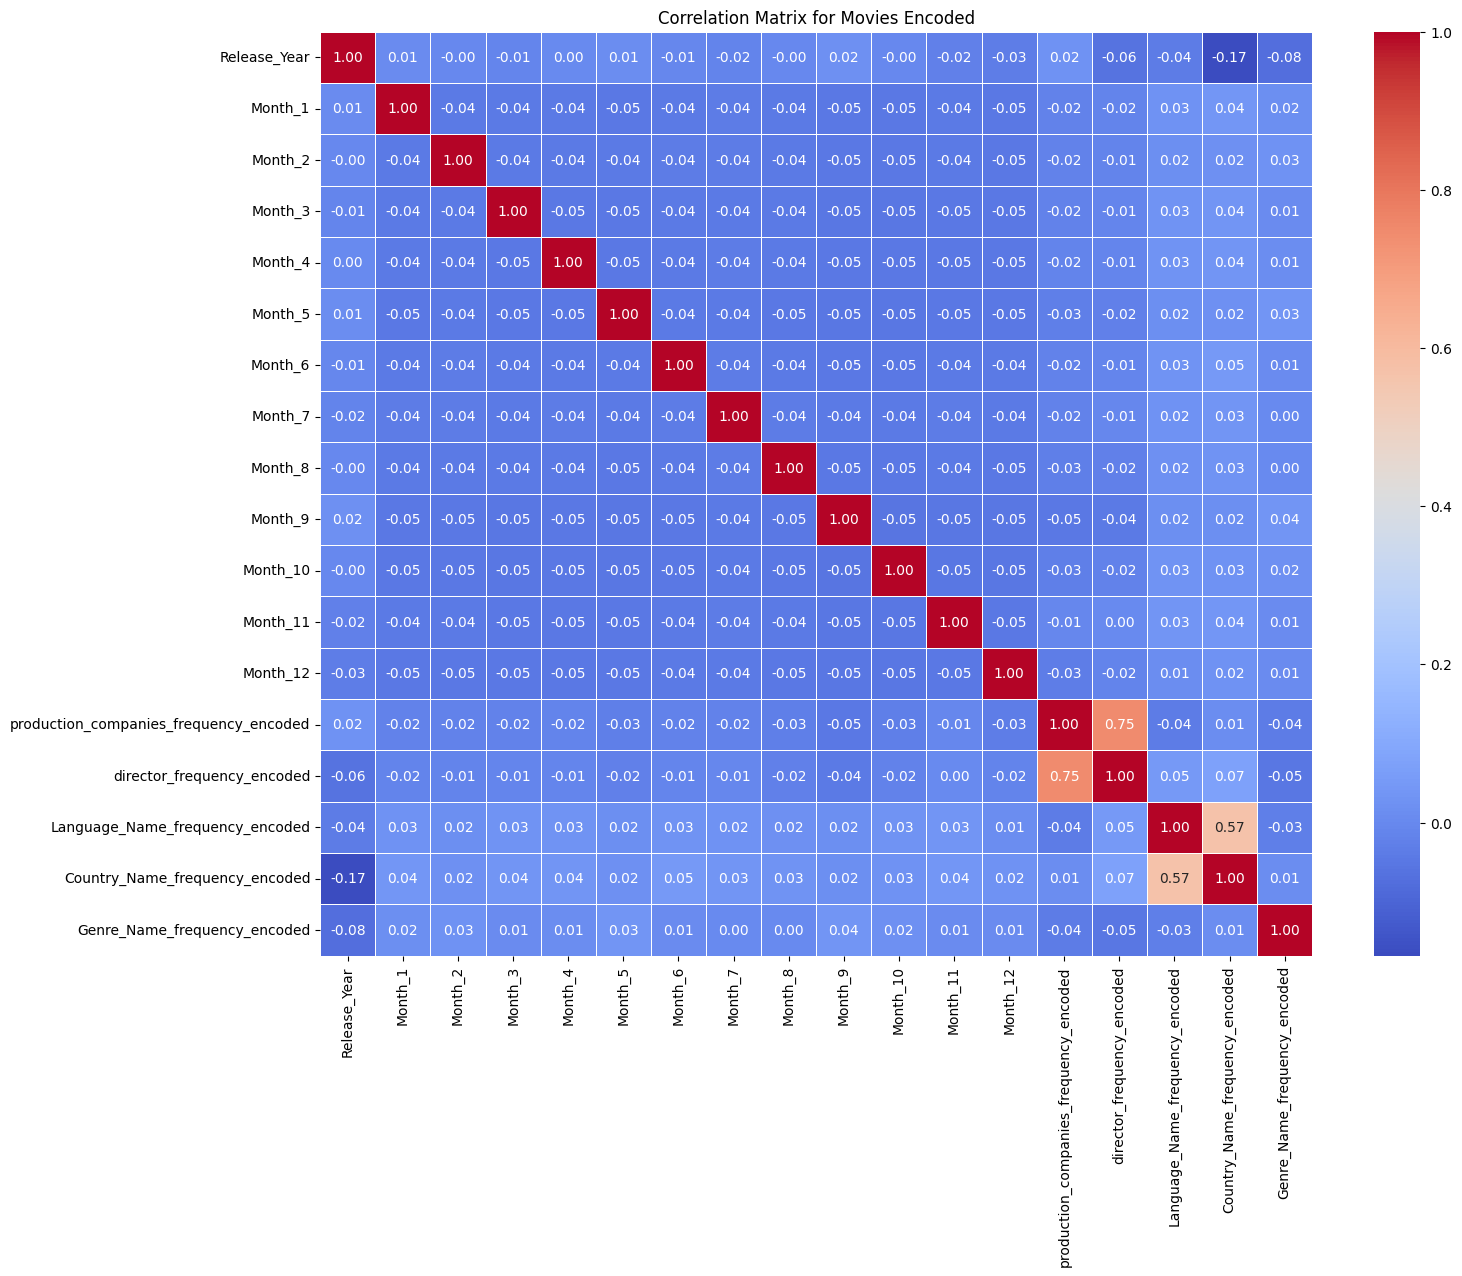

In [15]:
# Compute the correlation matrix
corr_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Movies Encoded')
plt.show()

We can see that there is almost no correlation between our variables, except for 2 clusters.

1. the columns **'director', 'writers', 'producers', 'production_companies'** seem to have high correlation after frequency encoding. this can likely be explained with the fact that famous directors tend to work with famous writers, producers and production companies.

2. The **language & country** show high correlation. This correlation comes naturally from the countries using their appropriate language.

We therefore include all of these variables in our final regression model, despite their high correlation.

## Linear Regression

We can finally use our prepared features to fit linear regression model.

In [16]:
targets.columns

Index(['IMDb_ID', 'imdb_rating', 'imdb_votes', 'Box Office Revenue'], dtype='object')

In [17]:
features_string = ' + '.join(features.columns)
categorical_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
                       'Month_10', 'Month_11', 'Month_12', 'is_american', 'is_uses_english']

# features_string = ' + '.join([f'C({col})' if col in categorical_columns else col for col in features.columns])
features_string = ' + '.join([col for col in features.columns])
# print(features_string)
print(f'Box Office Revenue ~  {features_string}')
# features.columns

Box Office Revenue ~  Release_Year + Month_1 + Month_2 + Month_3 + Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_10 + Month_11 + Month_12 + production_companies_frequency_encoded + director_frequency_encoded + Language_Name_frequency_encoded + Country_Name_frequency_encoded + Genre_Name_frequency_encoded


### Box Office Revenue

Only keep the rows which have all the values

In [18]:
import statsmodels.formula.api as smf

relevant_columns = list(features.columns) + ['Box_Office_Revenue']
box_office_analysis = movies_encoded[relevant_columns]
box_office_analysis = box_office_analysis.dropna()
box_office_analysis['Box_Office_Revenue'] = box_office_analysis['Box_Office_Revenue'].astype(float)

mod = smf.ols(formula=f'Box_Office_Revenue ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Box_Office_Revenue   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     34.40
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          7.97e-116
Time:                        16:55:46   Log-Likelihood:            -1.8918e+05
No. Observations:                9427   AIC:                         3.784e+05
Df Residuals:                    9408   BIC:                         3.785e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### IMDB Rating

In [19]:
relevant_columns = list(features.columns) + ['imdb_rating']
box_office_analysis = movies_encoded[relevant_columns]
box_office_analysis = box_office_analysis.dropna()

mod = smf.ols(formula=f'imdb_rating ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            imdb_rating   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     157.0
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:55:46   Log-Likelihood:                -81936.
No. Observations:               53938   AIC:                         1.639e+05
Df Residuals:                   53919   BIC:                         1.641e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Predict if score is above a threshold
We can also fit a model to predict whether a score is above a certain threshold

In [20]:
# model to predict if imdb_rating > threshold
threshold = 8

relevant_columns = list(features.columns) + ['imdb_rating']
box_office_analysis = movies_encoded[relevant_columns]
box_office_analysis = box_office_analysis.dropna()
box_office_analysis['imdb_rating_above_threshold'] = (box_office_analysis['imdb_rating'] > threshold).astype(int)

mod = smf.logit(formula=f'imdb_rating_above_threshold ~  {features_string}', data=box_office_analysis)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.117569
         Iterations 8
                                Logit Regression Results                               
Dep. Variable:     imdb_rating_above_threshold   No. Observations:                53938
Model:                                   Logit   Df Residuals:                    53919
Method:                                    MLE   Df Model:                           18
Date:                         Fri, 15 Nov 2024   Pseudo R-squ.:                 0.03736
Time:                                 16:55:46   Log-Likelihood:                -6341.5
converged:                                True   LL-Null:                       -6587.6
Covariance Type:                     nonrobust   LLR p-value:                 4.419e-93
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------